The goal of this post is to write some code that can generate direct^[**NOT** using a Markov Chain Monte Carlo (MCMC) method.] samples from a Cauchy Markov Random Field (CMRF) [@Chada2021] [@Markkanen2019] on a 2D regular lattice. A more general [Markov Random Field](https://en.wikipedia.org/wiki/Markov_random_field) (MRF) is just a (multivariate) probability distribution possessing a special conditional-independence property amongst the components. This property permits the use of efficient numerical methods developed to exploit this property. CMRFs are cousins of the better-known Gaussian Markov Random Fields (GMRFs), which are themselves special cases of Gaussian Random Fields (a.k.a. [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process)). 

Our main reference for this post will be [@Rue2005], which is a comprehensive text on the subject. Our plan of attack is to:

1. sample from a 1D GMRF,
2. build off this to sample a 1D CMRF using a hierarchical representation of the Cauchy distribution,
3. sample from a 2D GMRF,
4. build off this to sample from a 2D CMRF (our goal).

# Gaussian Markov Random Fields

A GMRF can be thought of as simply a multivariate random variable
$$
X \sim \mathcal{N}\left( \mu, Q^{-1} \right)
$$
with mean vector $\mu$ and precision^[a.k.a. covariance $\Sigma = Q^{-1}$] $Q$, where $Q$ is a sparse banded matrix^[Or is under some re-ordering of the components.] The reason we care about the sparsity of $Q$ rather than the covariance $\Sigma$ is because the precision matrix encodes the conditional independence structure of the field, whereas the covariance matrix will be dense even if the precision is sparse.

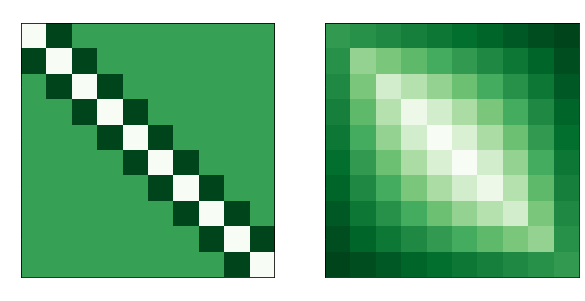

In [19]:
#| label: fig-prec_vs_cov
#| fig-cap: A sparse precision matrix will generally invert to a dense covariance matrix.

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = '#0F2537'

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'


prec_mat = 2*sp.eye(10)
prec_mat.setdiag(-1,k=-1)
prec_mat.setdiag(-1,k=1)
prec_mat = prec_mat.toarray()
cov_mat = np.linalg.inv(prec_mat)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(prec_mat, cmap='Greens_r')
axs[0].set_title("Precision")
axs[1].imshow(cov_mat, cmap='Greens_r')
axs[1].set_title("Covariance")

plt.show()


The unnormalized density function for the GMRF is given as
$$
\pi(x) \propto \exp\left[ - \frac{1}{2} \left( x - \mu \right)^T Q \left( x - \mu \right) \right].
$$

# Sampling a 1D GMRF

We might be tempted to sample a GMRF naively with the typical method, which is to multiply a standard normal vector by the Cholesky factor $L$ in the cholesky decomposition $Sigma = L L^T$ and then add the mean. In terms of the precision, this is equivalent to instead computing the Cholesky factorization $Q = L L^T$ and computing 
$$
x = \mu + L^{}
$$

 Consider the GMRF with zero mean and precision $Q = D^T D$, where
$$
D = \left(\begin{array}{ccccc} 
1  &    &          &          &   \\
-1 & 1  &          &          &   \\
   & -1 & 1        &          &   \\
   &    & \ddots & \ddots &   \\
   &    &          & -1       & 1
\end{array}\right).
$$ 
Intuitively, this precision corresponds to a Gaussian random-walk on the line whose increments have distribution $\Delta x_i \sim \mathcal{N}(0,1)$ and initial value has distribution $x_0 \sim \mathcal{N}(0,1)$. Let's draw a sample from this.

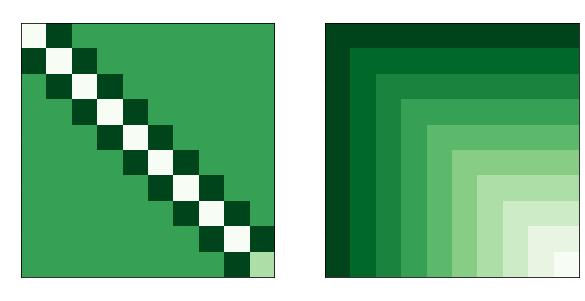

In [54]:
#| label: fig-random_walk_prec_cov
#| fig-cap: Precision and covariance matrices for the random walk.

N = 10
d_mat = sp.eye(N)
d_mat.setdiag(-1,k=-1)

prec_mat = d_mat.T @ d_mat
prec_mat = prec_mat.toarray()
cov_mat = np.linalg.inv(prec_mat)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(prec_mat, cmap='Greens_r')
axs[0].set_title("Precision")
axs[1].imshow(cov_mat, cmap='Greens_r')
axs[1].set_title("Covariance")

plt.show()


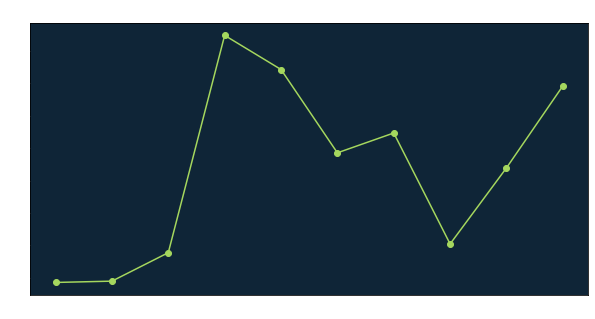

In [55]:
#| label: fig-random_walk_draw
#| fig-cap: A single draw from the random-walk GMRF.

chol_fac = np.linalg.cholesky(cov_mat)
z = np.random.normal(size=N)
sample = chol_fac @ z

fig, axs = plt.subplots(figsize=(10,5))
axs.plot(sample, "o-", color="#A5D75E")
axs.set_title("A single draw from the random walk on the line")
plt.show()

These examples with the number of points $N = 10$ worked fine. Now let's do a naive experiment, where we time how long it takes to compute a single sample as we increase $N$.

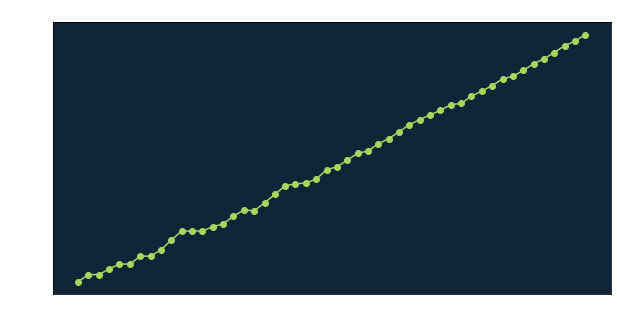

In [75]:
#| label: fig-random_walk_increasing_n
#| fig-cap: Time to generate a single sample vs. number of points N.

import time
from sklearn import datasets, linear_model

ns = np.logspace(2.5, 4, num=50)
ns = np.rint(ns).astype(np.int32)

def draw_single_sample(n):
    """Draws a single sample from the RW model of size n.
    """
    d_mat = sp.eye(n)
    d_mat.setdiag(-1,k=-1)

    prec_mat = d_mat.T @ d_mat
    prec_mat = prec_mat.toarray()
    cov_mat = np.linalg.inv(prec_mat)

    chol_fac = np.linalg.cholesky(cov_mat)
    z = np.random.normal(size=n)
    sample = chol_fac @ z
    
    return None

import time

times = []
for n in ns:
    start = time.time()
    draw_single_sample(n)
    end = time.time()
    elapsed = end - start
    times.append(elapsed)

regr = linear_model.LinearRegression()
regr.fit(np.log(ns)[:, None], np.log(times)[:, None])
slope = regr.coef_[0][0]

fig, axs = plt.subplots(figsize=(10,5))
axs.loglog(ns, times, "o-", color="#A5D75E")
axs.set_xlabel("N")
axs.set_ylabel("Time (seconds)")
axs.set_title(f"Time to generate one sample, increasing N (slope = {slope:.1f})")
plt.show()

The bottleneck we see here comes from the choles

In [46]:
# #| label: fig-random_walk_prec_cov
# #| fig-cap: A sparse precision matrix will generally invert to a dense covariance matrix.

# N = 10000
# d_mat = sp.eye(N)
# d_mat.setdiag(-1,k=-1)

# prec_mat = d_mat.T @ d_mat
# prec_mat = prec_mat.toarray()
# cov_mat = np.linalg.inv(prec_mat)

# chol_fac = np.linalg.cholesky(cov_mat)
# z = np.random.normal(size=N)
# sample = chol_fac @ z

# plt.plot(sample)
# plt.show()

In [57]:
10**4

10000

In [56]:
np.logspace(0, 4, num=30)

array([1.00000000e+00, 1.37382380e+00, 1.88739182e+00, 2.59294380e+00,
       3.56224789e+00, 4.89390092e+00, 6.72335754e+00, 9.23670857e+00,
       1.26896100e+01, 1.74332882e+01, 2.39502662e+01, 3.29034456e+01,
       4.52035366e+01, 6.21016942e+01, 8.53167852e+01, 1.17210230e+02,
       1.61026203e+02, 2.21221629e+02, 3.03919538e+02, 4.17531894e+02,
       5.73615251e+02, 7.88046282e+02, 1.08263673e+03, 1.48735211e+03,
       2.04335972e+03, 2.80721620e+03, 3.85662042e+03, 5.29831691e+03,
       7.27895384e+03, 1.00000000e+04])

For a demonstration of a line plot on a polar axis, see @fig-polar.


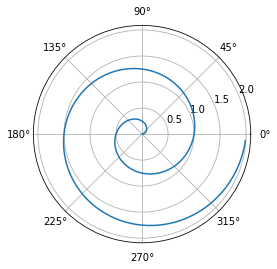

In [3]:
#| label: fig-polar
#| fig-cap: A line plot on a polar axis

import numpy as np
import matplotlib.pyplot as plt

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig, ax = plt.subplots(
  subplot_kw = {'projection': 'polar'} 
)
ax.plot(theta, r)
ax.set_rticks([0.5, 1, 1.5, 2])
ax.grid(True)
plt.show()

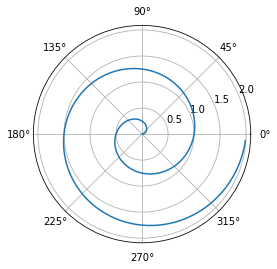

In [5]:
#| label: fig-polar2
#| fig-cap: A line plot on a polar axis

import numpy as np
import matplotlib.pyplot as plt

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig, ax = plt.subplots(
  subplot_kw = {'projection': 'polar'} 
)
ax.plot(theta, r)
ax.set_rticks([0.5, 1, 1.5, 2])
ax.grid(True)
plt.show()

For a demonstration of a line plot on a polar axis, see @fig-polar.


# Does this work?